In [10]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel.data import PanelData
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
import matplotlib.pyplot as plt
from plot_result import plot_result

In [11]:
df=pd.read_csv("../../data/merged/len3_ship_mon_DN.csv",encoding="shift-jis",index_col=0)
df["ship_date"]

C:\Users\hakos\AppData\Local\Temp\ipykernel_15704\3687484584.py:1: DtypeWarning: Columns (6,9,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("../../data/merged/len3_ship_mon_DN.csv",encoding="shift-jis",index_col=0)


0       2009-01-31
1       2009-02-28
2       2009-03-31
3       2009-04-30
4       2009-05-31
           ...    
4195    2022-08-31
4196    2022-09-30
4197    2022-10-31
4198    2022-11-30
4199    2022-12-31
Name: ship_date, Length: 4200, dtype: object

Estimation

In [12]:
df=pd.concat([df,pd.get_dummies(df["month"],prefix="mon")],axis=1)
df["mon_1"]

0       1
1       0
2       0
3       0
4       0
       ..
4195    0
4196    0
4197    0
4198    0
4199    0
Name: mon_1, Length: 4200, dtype: uint8

In [13]:
# normalization of year
# 2008で正規化するかで結構estimateが変わります、1ぐらい
# df["year"]=df["year"]-2008

#前処理
df.replace('-',"0",inplace=True)
df["otc_dom"].replace(",","",regex=True,inplace=True)
df["rx_dom"].replace(",","",regex=True,inplace=True)
df["stock_otc_lag"].replace(",","",regex=True,inplace=True)
df["stock_rx_lag"].replace(",","",regex=True,inplace=True)
# fillna
df["otc_dom"].fillna(0,inplace=True)
df["rx_dom"].fillna(0,inplace=True)
df["stock_otc_lag"].fillna(0,inplace=True)
df["stock_rx_lag"].fillna(0,inplace=True)

df["otc_dom"]=df["otc_dom"].astype(int)
df["rx_dom"]=df["rx_dom"].astype(int)
df["stock_otc_lag"]=df["stock_otc_lag"].astype(int)
df["stock_rx_lag"]=df["stock_rx_lag"].astype(float)
#ここはかなり重要でセレクションバイアスみたいなので有意性が変わるらしい
df=df.loc[df["otc_dom"]>0]
df=df.loc[df["rx_dom"]>0]
df=df.loc[df["stock_otc_lag"]>0]
df=df.loc[df["stock_rx_lag"]>0]
df=df.loc[df["generic_share_q"]>0]

# make log columns
df["log_rx_dom"]=np.log(df["rx_dom"])
df["log_otc_dom"]=np.log(df["otc_dom"])
df["log_stock_rx_lag"]=np.log(df["stock_rx_lag"])
df["log_stock_otc_lag"]=np.log(df["stock_otc_lag"])

# make year trend
df["year_trend"]=df["year"]-2008

In [14]:
# change to the datetime format
df['ship_date'] = pd.to_datetime(df["ship_date"], format='%Y-%m-%d')
df=df.set_index(["id","ship_date"])
# df=df.set_index(["id","year"])

df.info()
# make this to paneldata
df=PanelData(df,convert_dummies=False)
df.shape

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2752 entries, (114, Timestamp('2009-02-28 00:00:00')) to (799, Timestamp('2022-12-31 00:00:00'))
Columns: 641 entries, year to year_trend
dtypes: float64(14), int32(3), int64(603), object(9), uint8(12)
memory usage: 13.2+ MB


(641, 167, 19)

In [15]:
months="+mon_1+mon_2+mon_3+mon_4+mon_5+mon_6+mon_7+mon_8+mon_9+mon_10+mon_11+mon_12"
ytrend="+year_trend"

stockのlag(むしろgeneric?)とtime effectは共存できないらしい

elapsed dummies


In [16]:
before_p=10*12
after_p=15*12
elapsed = ''.join(["+elapsed_m" + str(i) for i in range(before_p, 1, -1)])
elapsed=elapsed+''.join(["+elapsed_" + str(i) for i in range(0,after_p+1)])
print(elapsed)

+elapsed_m120+elapsed_m119+elapsed_m118+elapsed_m117+elapsed_m116+elapsed_m115+elapsed_m114+elapsed_m113+elapsed_m112+elapsed_m111+elapsed_m110+elapsed_m109+elapsed_m108+elapsed_m107+elapsed_m106+elapsed_m105+elapsed_m104+elapsed_m103+elapsed_m102+elapsed_m101+elapsed_m100+elapsed_m99+elapsed_m98+elapsed_m97+elapsed_m96+elapsed_m95+elapsed_m94+elapsed_m93+elapsed_m92+elapsed_m91+elapsed_m90+elapsed_m89+elapsed_m88+elapsed_m87+elapsed_m86+elapsed_m85+elapsed_m84+elapsed_m83+elapsed_m82+elapsed_m81+elapsed_m80+elapsed_m79+elapsed_m78+elapsed_m77+elapsed_m76+elapsed_m75+elapsed_m74+elapsed_m73+elapsed_m72+elapsed_m71+elapsed_m70+elapsed_m69+elapsed_m68+elapsed_m67+elapsed_m66+elapsed_m65+elapsed_m64+elapsed_m63+elapsed_m62+elapsed_m61+elapsed_m60+elapsed_m59+elapsed_m58+elapsed_m57+elapsed_m56+elapsed_m55+elapsed_m54+elapsed_m53+elapsed_m52+elapsed_m51+elapsed_m50+elapsed_m49+elapsed_m48+elapsed_m47+elapsed_m46+elapsed_m45+elapsed_m44+elapsed_m43+elapsed_m42+elapsed_m41+elapsed_m40+elapse

## RX

                                  Parameter Estimates                                   
                      Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------------
elapsed_m120             0.0428     0.1580     0.2709     0.7865     -0.2670      0.3527
elapsed_m119             0.1238     0.1698     0.7293     0.4659     -0.2091      0.4567
elapsed_m118            -0.0437     0.1828    -0.2388     0.8113     -0.4021      0.3148
elapsed_m117             0.1734     0.2332     0.7437     0.4572     -0.2838      0.6306
elapsed_m116             0.0016     0.2428     0.0064     0.9949     -0.4746      0.4777
elapsed_m115             0.0185     0.1537     0.1205     0.9041     -0.2829      0.3199
elapsed_m114             0.0140     0.2564     0.0547     0.9564     -0.4889      0.5169
elapsed_m113             0.0413     0.1943     0.2128     0.8315     -0.3396      0.4223
elapsed_m112         

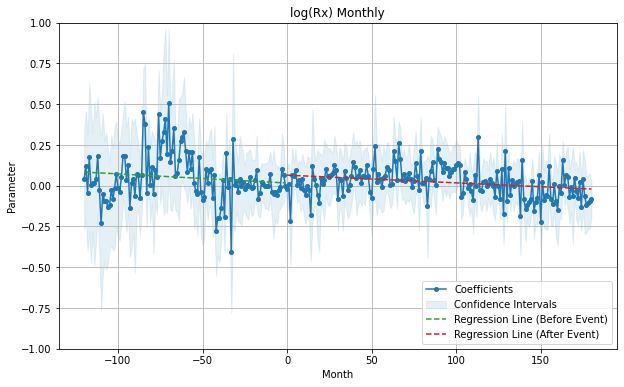

In [17]:
# take log
formula="log_rx_dom ~ "+elapsed


# log_stock_rx_lag
formula+=" + log_stock_rx_lag"
# ytrend
# formula+=ytrend
# months
# formula+=months
# generic_share_r
# formula+=" + generic_share_r"
# # generic_share_q
# formula+=" + generic_share_q"
formula+=" + log(generic_share_q)"

# fixed effects
formula+="+ TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True,check_rank=False)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
plot_result(res_fe,file_name="rx_log_mon",title="log(Rx) Monthly",period=before_p+after_p,insert_index=before_p-1,time_start=-before_p,markersize=4,xlabel="Month")

### OTC

                                  Parameter Estimates                                   
                      Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------------
elapsed_m120             0.4379     0.4666     0.9386     0.3480     -0.4770      1.3529
elapsed_m119            -0.0942     0.3784    -0.2488     0.8035     -0.8363      0.6480
elapsed_m118            -0.3370     0.3347    -1.0068     0.3142     -0.9934      0.3194
elapsed_m117             0.3314     0.5264     0.6297     0.5290     -0.7008      1.3636
elapsed_m116            -0.2847     0.3219    -0.8844     0.3766     -0.9159      0.3465
elapsed_m115            -0.3433     0.3542    -0.9692     0.3325     -1.0378      0.3513
elapsed_m114            -0.4373     0.3547    -1.2330     0.2177     -1.1328      0.2582
elapsed_m113            -0.0802     0.2300    -0.3488     0.7273     -0.5313      0.3709
elapsed_m112         

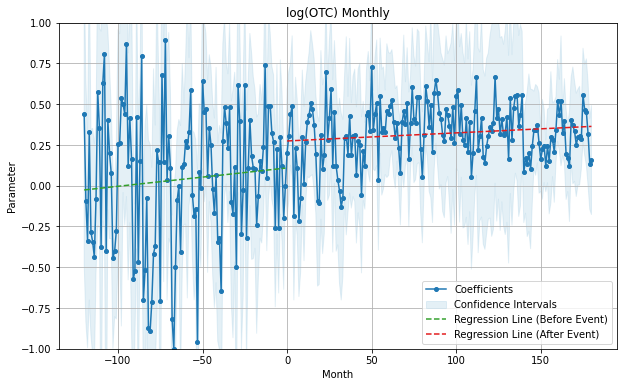

In [18]:
# take log

# till 20
# formula="log_otc_dom ~ elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15+elapsed_16+elapsed_17+elapsed_18+elapsed_19+elapsed_20+generic_per+TimeEffects+EntityEffects"

# take log
formula="log_otc_dom ~ "+elapsed


# log_stock_otc_lag
formula+=" + log_stock_otc_lag"

# ytrend
# formula+=ytrend
# months
# formula+=months
# generic_share_r
# formula+=" + log(generic_per)"
# formula+=" + generic_share_r"
# # generic_share_q
# formula+=" + generic_share_q"
formula+=" + log(generic_share_q)"

formula+="+ TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# res_fe=mod_fe.fit()
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
# print(res_fe)
plot_result(res_fe,file_name="otc_log_mon",title="log(OTC) Monthly",plot_type="-o",period=before_p+after_p,insert_index=before_p-1,time_start=-before_p,markersize=4,xlabel="Month")